In [11]:
import torch
import torch.nn as nn
from tqdm import tqdm
import sys
import numpy as np
import os
sys.path.append(os.path.abspath('../data'))
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import PackedSequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
import re

In [12]:


def tokenize(expression):
    """Convert expression string to tokens, preserving operators."""
    # Replace parentheses with spaces
    expr = expression.replace('(', ' ').replace(')', ' ')

    # Add spaces around brackets that aren't part of operators
    expr = re.sub(r'\[(?!(MIN|MAX|MED|SM))', ' [ ', expr)
    expr = expr.replace(']', ' ] ')

    # Split and filter empty strings
    return [token for token in expr.split() if token]

class ListOpsDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X: Array of source expressions
            y: Array of target values
        """
        self.X = X
        self.y = y

        # Create vocabulary from operators and digits
        self.vocab = {
            'PAD': 0,  # Padding token
            '[MIN': 1,
            '[MAX': 2,
            '[MED': 3,
            '[SM': 4,
            ']': 5,
            '(': 6,
            ')': 7
        }
        # Add digits 0-9
        for i in range(10):
            self.vocab[str(i)] = i + 8

    def __len__(self):
        return len(self.X)

    def tokenize(self, expr):
        """Convert expression to token IDs."""
        tokens = tokenize(expr)  # Using our previous tokenize function
        return [self.vocab.get(token, 0) for token in tokens]

    def __getitem__(self, idx):
        expr = self.X[idx]
        target = self.y[idx]

        # Convert to token IDs without padding or truncating
        token_ids = self.tokenize(expr)

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.long)
        }

In [13]:

# Define the data directory and file paths
data_dir = '/kaggle/input/output-dir'
train_file = os.path.join(data_dir, 'basic_train.tsv')
val_file = os.path.join(data_dir, 'basic_val.tsv')
test_file = os.path.join(data_dir, 'basic_test.tsv')

def load_listops_data(file_path, max_rows=None):
    """
    Load ListOps data from TSV file.

    Args:
        file_path: Path to the TSV file
        max_rows: Maximum number of rows to load (for testing)

    Returns:
        sources: Array of source expressions
        targets: Array of target values (0-9)
    """
    sources = []
    targets = []

    with open(file_path, 'r', encoding='utf-8') as f:
        next(f)  # Skip header (Source, Target)
        for i, line in enumerate(f):
            if max_rows and i >= max_rows:
                break
            if not line.strip():  # Skip empty lines
                continue
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue  # Skip lines that don't have exactly two columns
            source, target = parts
            sources.append(source)
            targets.append(int(target))  # Target is always 0-9

    # Convert to numpy arrays
    source_array = np.array(sources, dtype=object)  # Keep expressions as strings
    target_array = np.array(targets, dtype=np.int32)  # Targets are integers

    return source_array, target_array

try:
    # Load training data
    print("Loading training data...")
    X_train, y_train = load_listops_data(train_file)

    # Load validation data
    print("Loading validation data...")
    X_val, y_val = load_listops_data(val_file)

    # Load test data
    print("Loading test data...")
    X_test, y_test = load_listops_data(test_file)

    # Print dataset statistics
    print("\nDataset sizes:")
    print(f"Training: {len(X_train)} examples")
    print(f"Validation: {len(X_val)} examples")
    print(f"Test: {len(X_test)} examples")

except Exception as e:
    print(f"Error occurred: {type(e).__name__}: {str(e)}")

Loading training data...
Loading validation data...
Loading test data...

Dataset sizes:
Training: 96000 examples
Validation: 2000 examples
Test: 2000 examples


In [14]:

def collate_fn(batch):
    # Separate sequences and targets
    sequences = [item['input_ids'] for item in batch]
    targets = [item['target'] for item in batch]

    # Get lengths of each sequence
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long, device=sequences[0].device)

    # Sort sequences by length in descending order for pack_padded_sequence
    lengths, sort_idx = lengths.sort(descending=True)
    sequences = [sequences[i] for i in sort_idx]
    targets = [targets[i] for i in sort_idx]

    # Pad sequences
    padded_sequences = pad_sequence(sequences, batch_first=True)
    packed_sequences = pack_padded_sequence(padded_sequences, lengths, batch_first=True, enforce_sorted=False)
    # Convert targets to tensor
    targets = torch.stack(targets)

    return {
        'input_ids': packed_sequences,
        'target': targets,
        'lengths': lengths
    }

In [15]:

# Create datasets
train_dataset = ListOpsDataset(X_train, y_train)
val_dataset = ListOpsDataset(X_val, y_val)
test_dataset = ListOpsDataset(X_test, y_test)

# Create dataloaders with collate_fn
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn
)

# Verify the data
print("Dataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Val: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")


Dataset sizes:
Train: 96000
Val: 2000
Test: 2000


In [16]:
# Validation function

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(batch)  # Pass the entire batch dictionary
            loss = criterion(outputs, batch['target'])

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch['target'].size(0)
            correct += predicted.eq(batch['target']).sum().item()

    return total_loss / len(val_loader), 100. * correct / total

# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [17]:
# First, add this class definition for Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

# Then modify the criterion initialization
criterion = FocalLoss(gamma=2)

In [18]:
# Training configuration
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0


In [25]:
class LSTMModel(nn.Module):
    def __init__(self,
                 vocab_size=18,
                 embedding_dim=128,
                 hidden_dim=256,
                 num_layers=2,
                 dropout=0.3):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, 10)
        self.dropout = nn.Dropout(dropout)


    def forward(self, batch):
        input_ids = batch['input_ids']
        lengths = batch['lengths']

        if isinstance(input_ids, PackedSequence):
            seq, lens = pad_packed_sequence(input_ids, batch_first=True)
            x = self.embedding(seq)
            x = self.dropout(x)
            x = pack_padded_sequence(x, lens, batch_first=True, enforce_sorted=False)
        else:
            x = self.embedding(input_ids)
            x = self.dropout(x)
            x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.lstm(x)
        
        # Concatenate the final hidden states from both directions
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        x = self.dropout(hidden_cat)
        x = self.fc(x)

        return x

# Training setup with optimized parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)

# Use a combination of CrossEntropy and Focal Loss
criterion = FocalLoss(gamma=2)

# Optimizer with better parameters
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0005,              
    weight_decay=0.02,      
    betas=(0.9, 0.999),    
    eps=1e-8
)
num_epochs = 3
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos'
)

batch_size = 64            
early_stopping = EarlyStopping(patience=7, min_delta=1e-4)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,       
    collate_fn=collate_fn
)


Starting training...


Epoch 1/3: 100%|██████████| 1500/1500 [11:03<00:00,  2.26it/s, loss=0.0181, acc=39.30%, lr=0.000843]



Epoch: 1/3
Train Loss: 1.1575 | Train Acc: 39.30%
Val Loss: 1.0530 | Val Acc: 40.80%
--------------------------------------------------


Epoch 2/3: 100%|██████████| 1500/1500 [11:05<00:00,  2.25it/s, loss=0.0161, acc=43.68%, lr=0.000302]



Epoch: 2/3
Train Loss: 1.0329 | Train Acc: 43.68%
Val Loss: 1.0077 | Val Acc: 45.10%
--------------------------------------------------


Epoch 3/3: 100%|██████████| 1500/1500 [11:09<00:00,  2.24it/s, loss=0.0155, acc=46.14%, lr=0.000000]



Epoch: 3/3
Train Loss: 0.9925 | Train Acc: 46.14%
Val Loss: 1.0000 | Val Acc: 45.00%
--------------------------------------------------

Testing best model...


/tmp/ipykernel_23/852413796.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_lstm_model.pth')


Test Loss: 0.9871 | Test Acc: 47.05%


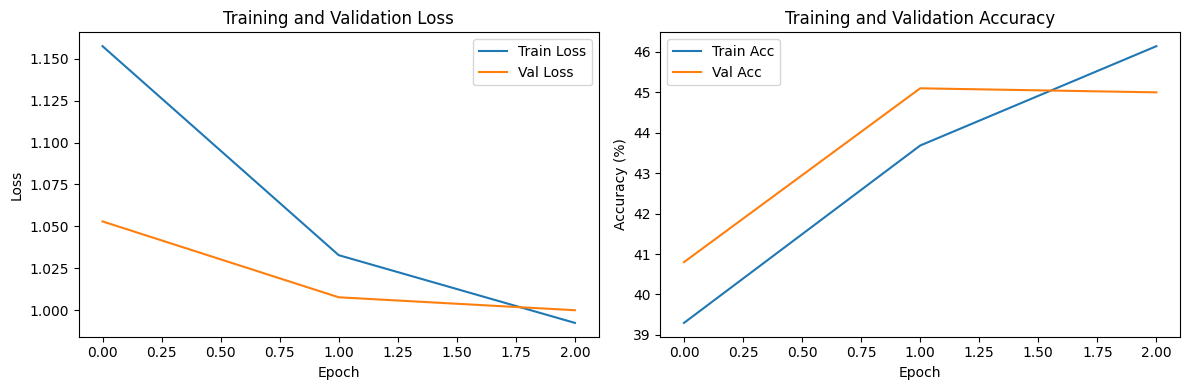


Training Summary:
Best Validation Accuracy: 45.10%
Final Test Accuracy: 47.05%
Total Epochs Trained: 3


In [26]:
# Training loop
print("\nStarting training...")
best_val_acc = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    # Training phase
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch in pbar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch)
        loss = criterion(outputs, batch['target'])
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        
        # Learning rate scheduler step
        scheduler.step()
        
        # Calculate accuracy
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += batch['target'].size(0)
        correct += predicted.eq(batch['target']).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{train_loss/total:.4f}',
            'acc': f'{100.*correct/total:.2f}%',
            'lr': f'{scheduler.get_last_lr()[0]:.6f}'
        })
    
    # Calculate training metrics
    epoch_train_loss = train_loss/len(train_loader)
    epoch_train_acc = 100.*correct/total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation phase
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print epoch results
    print(f'\nEpoch: {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print('-' * 50)
    
    # Early stopping check
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        model.load_state_dict(early_stopping.best_model)
        break
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'best_lstm_model.pth')

# Load best model for testing
checkpoint = torch.load('best_lstm_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Test the model
print("\nTesting best model...")
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Print final results summary
print("\nTraining Summary:")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Total Epochs Trained: {epoch+1}")

In [27]:
# Test with best model
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')



Test Loss: 0.9871 | Test Acc: 47.05%


In [ ]:
torch.save(model.state_dict(), 'lstm_model.pth')


Starting training...


Epoch 2/15: 100%|██████████| 1500/1500 [11:15<00:00,  2.22it/s, loss=0.0167, acc=41.97%, lr=0.000997]



Epoch: 2/15
Train Loss: 1.0660 | Train Acc: 41.97%
Val Loss: 1.0358 | Val Acc: 42.65%
--------------------------------------------------


Epoch 3/15: 100%|██████████| 1500/1500 [11:18<00:00,  2.21it/s, loss=0.0161, acc=43.86%, lr=0.000970]



Epoch: 3/15
Train Loss: 1.0307 | Train Acc: 43.86%
Val Loss: 1.0124 | Val Acc: 43.85%
--------------------------------------------------


Epoch 4/15:  17%|█▋        | 250/1500 [01:53<09:35,  2.17it/s, loss=0.0158, acc=45.42%, lr=0.000963]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 4/15: 100%|██████████| 1500/1500 [11:20<00:00,  2.20it/s, loss=0.0157, acc=45.21%, lr=0.000918]



Epoch: 4/15
Train Loss: 1.0080 | Train Acc: 45.21%
Val Loss: 1.0007 | Val Acc: 44.40%
--------------------------------------------------


Epoch 5/15: 100%|██████████| 1500/1500 [11:23<00:00,  2.20it/s, loss=0.0155, acc=46.16%, lr=0.000843]



Epoch: 5/15
Train Loss: 0.9896 | Train Acc: 46.16%
Val Loss: 0.9909 | Val Acc: 44.20%
--------------------------------------------------


Epoch 6/15: 100%|██████████| 1500/1500 [11:24<00:00,  2.19it/s, loss=0.0140, acc=50.50%, lr=0.000750]



Epoch: 6/15
Train Loss: 0.8992 | Train Acc: 50.50%
Val Loss: 0.7972 | Val Acc: 54.75%
--------------------------------------------------


Epoch 8/15: 100%|██████████| 1500/1500 [11:21<00:00,  2.20it/s, loss=0.0113, acc=59.06%, lr=0.000529]



Epoch: 8/15
Train Loss: 0.7211 | Train Acc: 59.06%
Val Loss: 0.7386 | Val Acc: 57.95%
--------------------------------------------------


Epoch 9/15: 100%|██████████| 1500/1500 [11:21<00:00,  2.20it/s, loss=0.0107, acc=61.15%, lr=0.000413]



Epoch: 9/15
Train Loss: 0.6875 | Train Acc: 61.15%
Val Loss: 0.7368 | Val Acc: 58.50%
--------------------------------------------------


Epoch 11/15: 100%|██████████| 1500/1500 [11:21<00:00,  2.20it/s, loss=0.0098, acc=64.68%, lr=0.000201]



Epoch: 11/15
Train Loss: 0.6274 | Train Acc: 64.68%
Val Loss: 0.7386 | Val Acc: 58.75%
--------------------------------------------------


Epoch 12/15: 100%|██████████| 1500/1500 [11:21<00:00,  2.20it/s, loss=0.0094, acc=66.01%, lr=0.000117]



Epoch: 12/15
Train Loss: 0.6022 | Train Acc: 66.01%
Val Loss: 0.7458 | Val Acc: 58.55%
--------------------------------------------------


Epoch 13/15: 100%|██████████| 1500/1500 [11:21<00:00,  2.20it/s, loss=0.0091, acc=67.40%, lr=0.000053]



Epoch: 13/15
Train Loss: 0.5809 | Train Acc: 67.40%
Val Loss: 0.7507 | Val Acc: 58.80%
--------------------------------------------------


Epoch 14/15: 100%|██████████| 1500/1500 [11:20<00:00,  2.20it/s, loss=0.0089, acc=68.12%, lr=0.000013]



Epoch: 14/15
Train Loss: 0.5686 | Train Acc: 68.12%
Val Loss: 0.7528 | Val Acc: 58.65%
--------------------------------------------------


Epoch 15/15: 100%|██████████| 1500/1500 [11:20<00:00,  2.20it/s, loss=0.0088, acc=68.32%, lr=0.000000]



Epoch: 15/15
Train Loss: 0.5632 | Train Acc: 68.32%
Val Loss: 0.7533 | Val Acc: 58.75%
--------------------------------------------------

Testing best model...


/tmp/ipykernel_23/209510888.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_lstm_model.pth')


Test Loss: 0.7171 | Test Acc: 59.50%


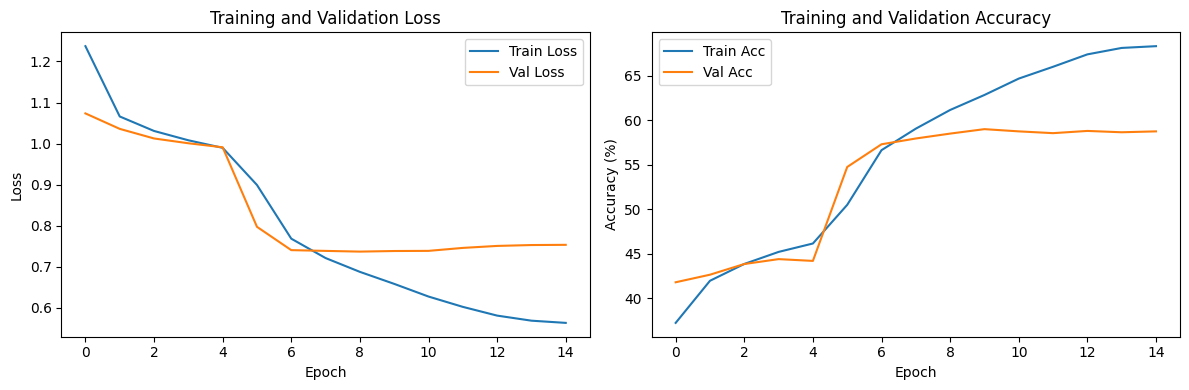


Training Summary:
Best Validation Accuracy: 59.00%
Final Test Accuracy: 59.50%
Total Epochs Trained: 15


In [29]:
# Training setup with optimized parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)

# Use a combination of CrossEntropy and Focal Loss
criterion = FocalLoss(gamma=2)

# Optimizer with better parameters
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0005,              
    weight_decay=0.02,      
    betas=(0.9, 0.999),    
    eps=1e-8
)
num_epochs = 15
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos'
)

batch_size = 64            
early_stopping = EarlyStopping(patience=7, min_delta=1e-4)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,       
    collate_fn=collate_fn
)
# Training loop
print("\nStarting training...")
best_val_acc = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    # Training phase
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch in pbar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch)
        loss = criterion(outputs, batch['target'])
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        
        # Learning rate scheduler step
        scheduler.step()
        
        # Calculate accuracy
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += batch['target'].size(0)
        correct += predicted.eq(batch['target']).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{train_loss/total:.4f}',
            'acc': f'{100.*correct/total:.2f}%',
            'lr': f'{scheduler.get_last_lr()[0]:.6f}'
        })
    
    # Calculate training metrics
    epoch_train_loss = train_loss/len(train_loader)
    epoch_train_acc = 100.*correct/total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation phase
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print epoch results
    print(f'\nEpoch: {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print('-' * 50)
    
    # Early stopping check
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        model.load_state_dict(early_stopping.best_model)
        break
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'best_lstm_model.pth')

# Load best model for testing
checkpoint = torch.load('best_lstm_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Test the model
print("\nTesting best model...")
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Print final results summary
print("\nTraining Summary:")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Total Epochs Trained: {epoch+1}")

In [30]:
# Test with best model
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')



Test Loss: 0.7171 | Test Acc: 59.50%
